# Set up

Install packages :

In [ ]:
%pip install lime


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Python librairies imports :

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.inspection import permutation_importance

import xgboost as xgb

import lime.lime_tabular

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(palette="Dark2")

Load data set from Google Drive :

In [ ]:
work_loc = 'local' # colab or local

project_path = "My Drive/OPENCLASSROOMS/Projets DATA/4. Consommation batiments"
csv_filename = "project4_data_cleaned.csv"

if(work_loc == 'colab'):
    # Mount Drive folder
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Drive path
    work_path = "/content/drive/"

elif(work_loc == 'local'):
    # Local drive path 
    work_path = "/Users/victor/Library/CloudStorage/GoogleDrive-vicozer@gmail.com/"

else:
    raise ValueError("Choose between 'colab' or 'local' work!")

# Get CSV file path 
csv_file = work_path + project_path + "/" + csv_filename

# Import csv file as dataframe
data = pd.read_csv(csv_file)

# Prepare the data set

In [ ]:
# Display cleaned df
display(data.head(10))

# Display NaN values
display(data.isna().sum())

Age  BuildType_Culture  BuildType_Education  BuildType_Healthcare  \
0   89                  0                    0                     0   
1   20                  0                    0                     0   
2   47                  0                    0                     0   
3   90                  0                    0                     0   
4   36                  0                    0                     0   
5   17                  0                    0                     0   
6   90                  0                    0                     0   
7   90                  1                    0                     0   
8  112                  0                    0                     0   
9   47                  0                    0                     0   

   BuildType_Hotel  BuildType_Industrial  BuildType_Office  BuildType_Other  \
0                1                     0                 0                0   
1                1                     0                 0                0   
2                1                     0                 0                0   
3                1                     0                 0                0   
4                1                     0                 0                0   
5                0                     0                 0                0   
6                1                     0                 0                0   
7                0                     0                 0                0   
8                1                     0                 0                0   
9                1                     0                 0                0   

   BuildType_Religion  BuildType_Restaurant  ...  Neighborhood_NORTHEAST  \
0                   0                     0  ...                       0   
1                   0                     0  ...                       0   
2                   0                     0  ...                       0   
3                   0                     0  ...                       0   
4                   0                     0  ...                       0   
5                   0                     0  ...                       0   
6                   0                     0  ...                       0   
7                   0                     0  ...                       0   
8                   0                     0  ...                       0   
9                   0                     0  ...                       0   

   Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   
5                       0                       0                       0   
6                       0                       0                       0   
7                       0                       0                       0   
8                       0                       0                       0   
9                       0                       0                       0   

   NumberofBuildings  NumberofFloors  PropertyGFABuildings(log10)  \
0                  1              12                     4.946619   
1                  1              11                     4.946953   
2                  1              41                     5.880466   
3                  1              10                     4.787602   
4                  1              18                     5.055302   
5                  1               2                     4.778802   
6                  1              11                     4.919120   
7                  1               8                     5.011828   
8                  1              

Age                                   0
BuildType_Culture                     0
BuildType_Education                   0
BuildType_Healthcare                  0
BuildType_Hotel                       0
BuildType_Industrial                  0
BuildType_Office                      0
BuildType_Other                       0
BuildType_Religion                    0
BuildType_Restaurant                  0
BuildType_Services                    0
BuildType_Stores                      0
ENERGYSTARScore                       0
Latitude                              0
Longitude                             0
Neighborhood_BALLARD                  0
Neighborhood_CENTRAL                  0
Neighborhood_DELRIDGE                 0
Neighborhood_DOWNTOWN                 0
Neighborhood_EAST                     0
Neighborhood_GREATER DUWAMISH         0
Neighborhood_LAKE UNION               0
Neighborhood_MAGNOLIA / QUEEN ANNE    0
Neighborhood_NORTH                    0
Neighborhood_NORTHEAST                0


## Define the target

The green house gas emissions are given by the variable TotalGHGEmissions.

In [ ]:
# Define target variable
target = 'SiteEnergyUse(log10)'

## Define the features

The features are the remaining columns.

In [ ]:
# Define features
features = data.select_dtypes(include=[np.number]).columns.to_list()

I remove the columns *TotalGHGEmissions* and *SiteEnergyUse(kBtu)* from the feature list.

In [ ]:
# Remove targets
features.remove('SiteEnergyUse(log10)')
features.remove('TotalGHGEmissions(log10)')

I also remove the variable *ENERGYSTARScore* that will be used later.

In [ ]:
# Remove energystar score
features.remove('ENERGYSTARScore')

In [ ]:
print("The target is :", target)
print("The features are :", features)

The target is : SiteEnergyUse(log10)
The features are : ['Age', 'BuildType_Culture', 'BuildType_Education', 'BuildType_Healthcare', 'BuildType_Hotel', 'BuildType_Industrial', 'BuildType_Office', 'BuildType_Other', 'BuildType_Religion', 'BuildType_Restaurant', 'BuildType_Services', 'BuildType_Stores', 'Latitude', 'Longitude', 'Neighborhood_BALLARD', 'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE', 'Neighborhood_DOWNTOWN', 'Neighborhood_EAST', 'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION', 'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH', 'Neighborhood_NORTHEAST', 'Neighborhood_NORTHWEST', 'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuildings(log10)', 'PropertyGFAParking']


## Define the one hot encoded columns

The one hot encoded columns (see exploration notebook) are the *BuildType_* and *Neighborhood_* ones.

In [ ]:
# One hot encoded prefix
ohe_prefix = ['BuildType_', 'Neighborhood_']

# Define the one hot encoded columns
ohe_columns = []
not_ohe_columns = []

for col in features:
  if any(prefix in col for prefix in ohe_prefix):
    ohe_columns.append(col)
  else: 
    not_ohe_columns.append(col)

print("The one hot encoded columns are : ", ohe_columns)

The one hot encoded columns are :  ['BuildType_Culture', 'BuildType_Education', 'BuildType_Healthcare', 'BuildType_Hotel', 'BuildType_Industrial', 'BuildType_Office', 'BuildType_Other', 'BuildType_Religion', 'BuildType_Restaurant', 'BuildType_Services', 'BuildType_Stores', 'Neighborhood_BALLARD', 'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE', 'Neighborhood_DOWNTOWN', 'Neighborhood_EAST', 'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION', 'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH', 'Neighborhood_NORTHEAST', 'Neighborhood_NORTHWEST', 'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']


## Define X and Y variables

I set the values for independent (X) variable and dependent (Y) variable for the prediction.

In [ ]:
#Setting the value for X and Y
x = data[features]
y = data[target]

print(x.shape)
print(y.shape)

(1596, 31)
(1596,)


I show the distributions of the features.

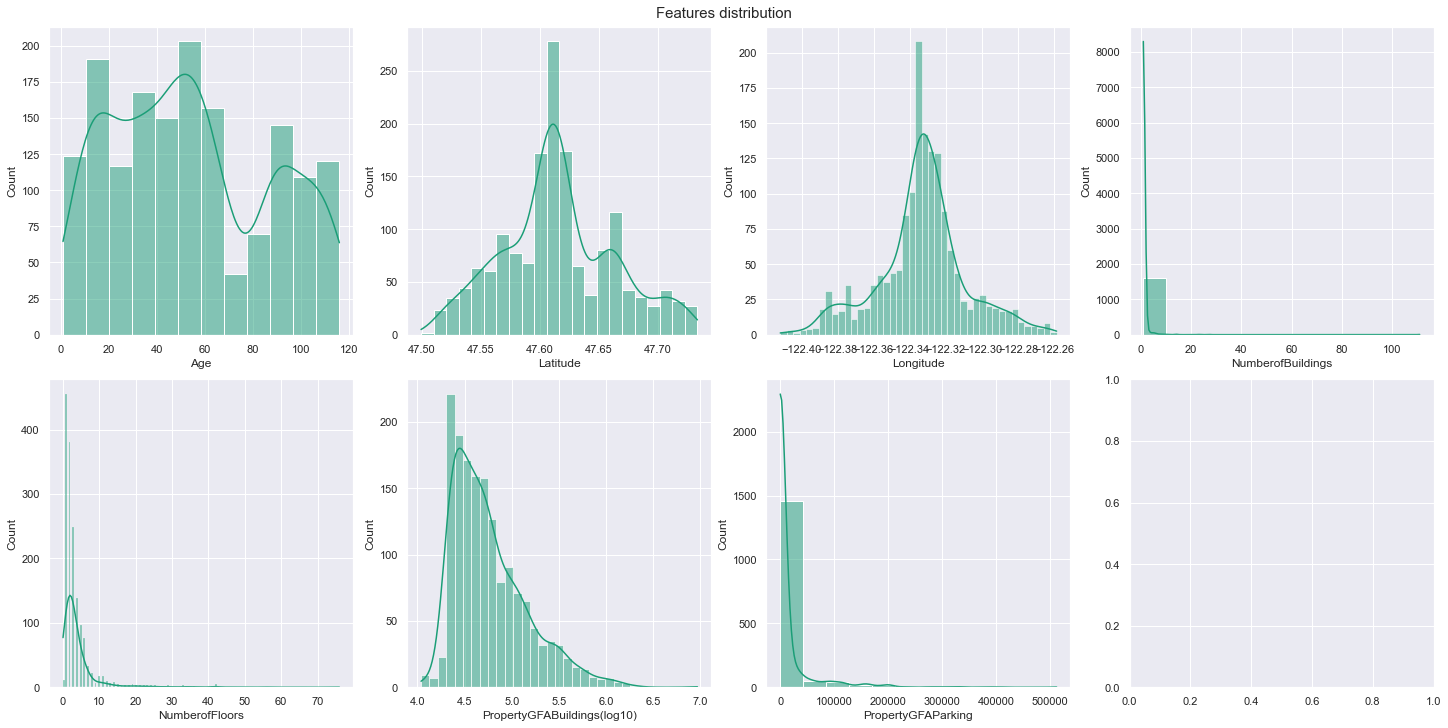

In [ ]:
# Init figure
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
plt.suptitle("Features distribution", fontsize=15)
i,j=0,0

for feature in not_ohe_columns:  
    # Draw distribution
    sns.histplot(data=x[feature], kde=True, ax=ax[i,j])
    j+=1
    if(j>3):
        j=0
        i+=1


And the target distribution.

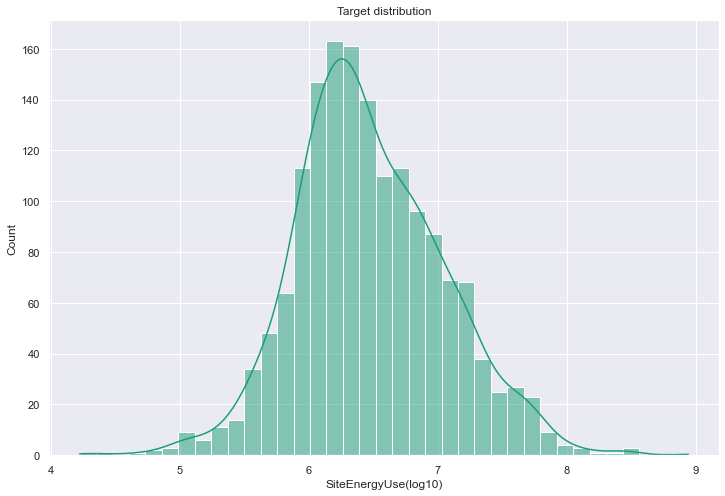

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Target distribution")
sns.histplot(data=y, kde=True)
plt.show()

# Training and testing sets 

First I need to split my data set to have:
* A training data set to train the regression models
* A testing data set to test the chosen model

I also take the occasion to standardize the dataset (all variable but the one hot encoded).

In [ ]:
# Create sets from x and y
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

display(x_train.describe())
display(x_test.describe())

Age  BuildType_Culture  BuildType_Education  \
count  1276.000000        1276.000000          1276.000000   
mean     54.644201           0.052508             0.108150   
std      32.406686           0.223136             0.310692   
min       1.000000           0.000000             0.000000   
25%      28.000000           0.000000             0.000000   
50%      52.000000           0.000000             0.000000   
75%      86.000000           0.000000             0.000000   
max     116.000000           1.000000             1.000000   

       BuildType_Healthcare  BuildType_Hotel  BuildType_Industrial  \
count           1276.000000      1276.000000           1276.000000   
mean               0.046238         0.046238              0.189655   
std                0.210083         0.210083              0.392182   
min                0.000000         0.000000              0.000000   
25%                0.000000         0.000000              0.000000   
50%                0.000000         0.000000              0.000000   
75%                0.000000         0.000000              0.000000   
max                1.000000         1.000000              1.000000   

       BuildType_Office  BuildType_Other  BuildType_Religion  \
count       1276.000000      1276.000000         1276.000000   
mean           0.318966         0.061129            0.043887   
std            0.466258         0.239660            0.204924   
min            0.000000         0.000000            0.000000   
25%            0.000000         0.000000            0.000000   
50%            0.000000         0.000000            0.000000   
75%            1.000000         0.000000            0.000000   
max            1.000000         1.000000            1.000000   

       BuildType_Restaurant  ...  Neighborhood_MAGNOLIA / QUEEN ANNE  \
count           1276.000000  ...                         1276.000000   
mean               0.007837  ...                            0.092476   
std                0.088214  ...                            0.289811   
min                0.000000  ...                            0.000000   
25%                0.000000  ...                            0.000000   
50%                0.000000  ...                            0.000000   
75%                0.000000  ...                            0.000000   
max                1.000000  ...                            1.000000   

       Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
count         1276.000000             1276.000000             1276.000000   
mean             0.039969                0.069749                0.054075   
std              0.195962                0.254824                0.226255   
min              0.000000                0.000000                0.000000   
25%              0.000000                0.000000                0.000000   
50%              0.000000                0.000000                0.000000   
75%              0.000000                0.000000                0.000000   
max              1.000000                1.000000                1.000000   

       Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  NumberofBuildings  \
count             1276.000000             1276.000000        1276.000000   
mean                 0.028213                0.026646           1.139498   
std                  0.165646                0.161109           1.246539   
min                  0.000000                0.000000           1.000000   
25%                  0.000000                0.000000           1.000000   
50%                  0.000000                0.000000           1.000000   
75%                  0.000000                0.000000           1.000000   
max                  1.000000                1.000000          27.000000   

       NumberofFloors  PropertyGFABuildings(log10)  PropertyGFAParking  
count     1276.000000                  1276.000000         1276.000000  
mean         4.047806                     4.761330        12824.904389  
s

Age  BuildType_Culture  BuildType_Education  \
count  320.000000         320.000000           320.000000   
mean    53.703125           0.050000             0.059375   
std     33.778682           0.218286             0.236695   
min      1.000000           0.000000             0.000000   
25%     25.000000           0.000000             0.000000   
50%     48.500000           0.000000             0.000000   
75%     87.000000           0.000000             0.000000   
max    116.000000           1.000000             1.000000   

       BuildType_Healthcare  BuildType_Hotel  BuildType_Industrial  \
count            320.000000       320.000000            320.000000   
mean               0.040625         0.059375              0.196875   
std                0.197729         0.236695              0.398260   
min                0.000000         0.000000              0.000000   
25%                0.000000         0.000000              0.000000   
50%                0.000000         0.000000              0.000000   
75%                0.000000         0.000000              0.000000   
max                1.000000         1.000000              1.000000   

       BuildType_Office  BuildType_Other  BuildType_Religion  \
count        320.000000       320.000000          320.000000   
mean           0.306250         0.075000            0.046875   
std            0.461657         0.263804            0.211702   
min            0.000000         0.000000            0.000000   
25%            0.000000         0.000000            0.000000   
50%            0.000000         0.000000            0.000000   
75%            1.000000         0.000000            0.000000   
max            1.000000         1.000000            1.000000   

       BuildType_Restaurant  ...  Neighborhood_MAGNOLIA / QUEEN ANNE  \
count            320.000000  ...                          320.000000   
mean               0.018750  ...                            0.087500   
std                0.135853  ...                            0.283009   
min                0.000000  ...                            0.000000   
25%                0.000000  ...                            0.000000   
50%                0.000000  ...                            0.000000   
75%                0.000000  ...                            0.000000   
max                1.000000  ...                            1.000000   

       Neighborhood_NORTH  Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  \
count          320.000000              320.000000              320.000000   
mean             0.037500                0.071875                0.040625   
std              0.190281                0.258685                0.197729   
min              0.000000                0.000000                0.000000   
25%              0.000000                0.000000                0.000000   
50%              0.000000                0.000000                0.000000   
75%              0.000000                0.000000                0.000000   
max              1.000000                1.000000                1.000000   

       Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  NumberofBuildings  \
count              320.000000              320.000000         320.000000   
mean                 0.018750                0.015625           1.471875   
std                  0.135853                0.124214           6.186685   
min                  0.000000                0.000000           1.000000   
25%                  0.000000                0.000000           1.000000   
50%                  0.000000                0.000000           1.000000   
75%                  0.000000                0.000000           1.000000   
max                  1.000000                1.000000         111.000000   

       NumberofFloors  PropertyGFABuildings(log10)  PropertyGFAParking  
count      320.000000                   320.000000          320.000000  
mean         4.243750                     4.766565        15704.500000  
std      

Then I decide to standardize all features that are not one hot encoded.

In [ ]:
# Standardize dataset
scaler = preprocessing.StandardScaler()

# Select non one hot encoded columns
features_to_scale  = not_ohe_columns

# Fit on train set
x_train[features_to_scale] = pd.DataFrame(scaler.fit_transform(x_train[features_to_scale]), index=x_train.index, columns=features_to_scale)
  
# Apply on test set
x_test[features_to_scale] = pd.DataFrame(scaler.transform(x_test[features_to_scale]), index=x_test.index, columns=features_to_scale)

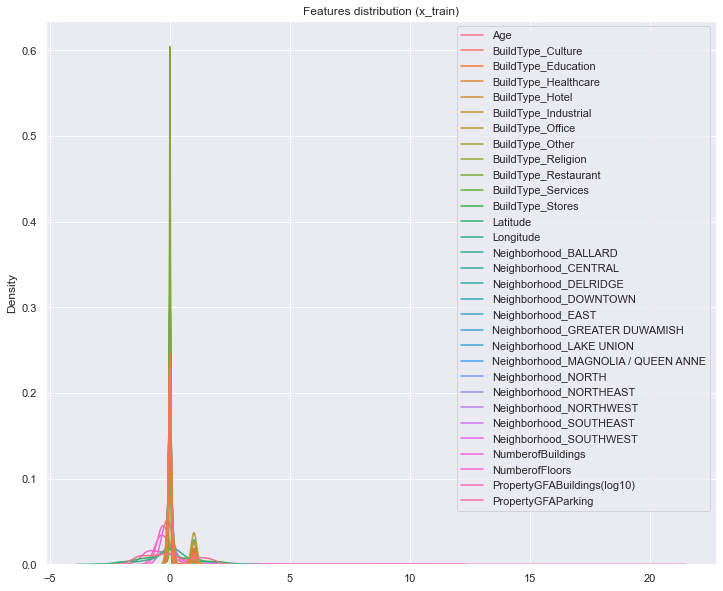

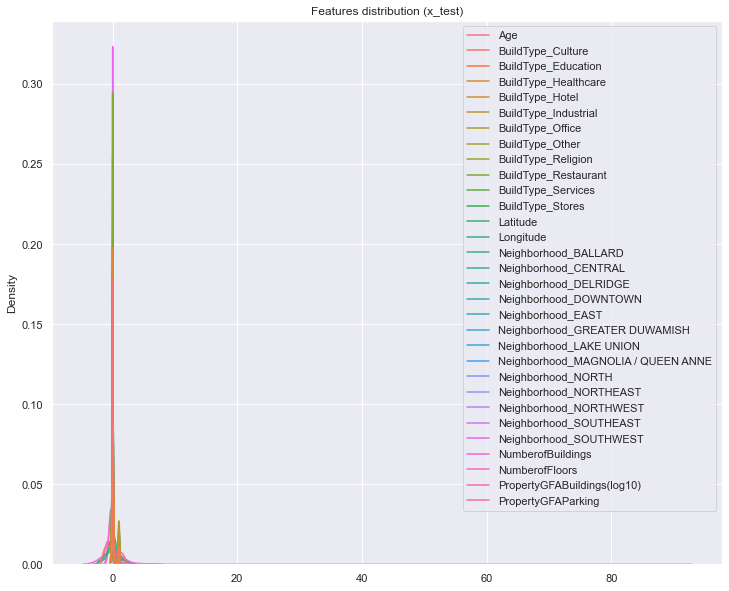

In [ ]:
# Display xtrain distribution
plt.figure(figsize=(12,10))
plt.title("Features distribution (x_train)")
sns.kdeplot(data=x_train)
plt.show()

# Display xtest distribution
plt.figure(figsize=(12,10))
plt.title("Features distribution (x_test)")
sns.kdeplot(data=x_test)
plt.show()

I compare the distributions of y_train and y_test to see if it's equally splitted.

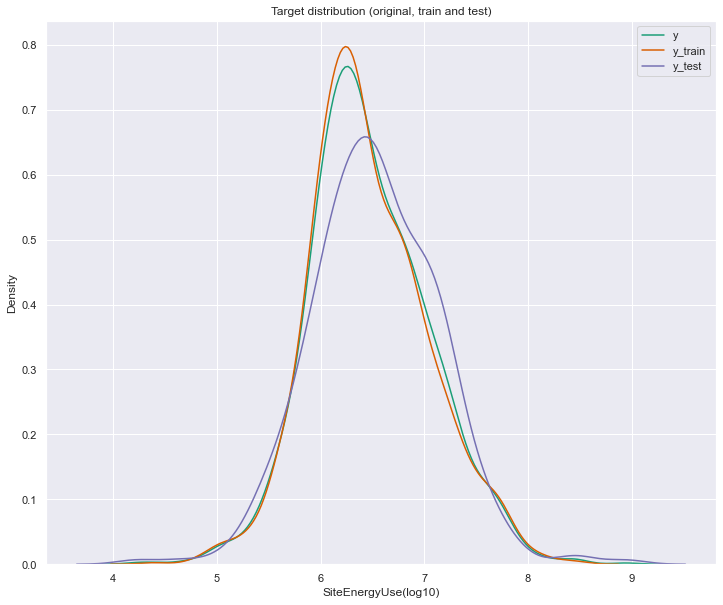

In [ ]:
# Display xtrain distribution
plt.figure(figsize=(12,10))
plt.title("Target distribution (original, train and test)")
sns.kdeplot(data=y)
sns.kdeplot(data=y_train)
sns.kdeplot(data=y_test)
plt.legend(labels=['y', 'y_train', 'y_test'])
plt.show()

# Apply the models

For this study I will test three differents machine learning models. They are regression algorithms as I need to predict a continuous value (here the green house gas emissions) :

* **Linear regression** : Ordinary least squares Linear Regression, it fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset.

* **Random forest regressor** : A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

* **Extrem gradient booster** : Gradient Boosting is a system of machine learning boosting, representing a decision tree for large and complex data. It relies on the presumption that the next possible model will minimize the gross prediction error if combined with the previous set of models. The decision trees are used for the best possible predictions. 

## Linear regression

I use the sklearn linear regression model.

In [ ]:
# Linear regression model
lr = LinearRegression()

I implement the linear model on the training set.

In [ ]:
# Fitting the Multiple Linear Regression model
lr.fit(x_train, y_train)

LinearRegression()

Let's see the differents coefficient of the model equation.

In [ ]:
# Intercept
print("Intercept: ", lr.intercept_)

# Coefficient
lr_importances = pd.Series(lr.coef_, index=features)
print("Coefficients:")
display(lr_importances)

Intercept:  6.560463446990509
Coefficients:


Age                                  -0.044221
BuildType_Culture                     0.129203
BuildType_Education                  -0.158595
BuildType_Healthcare                  0.262714
BuildType_Hotel                       0.059967
BuildType_Industrial                 -0.387288
BuildType_Office                     -0.075122
BuildType_Other                       0.000187
BuildType_Religion                   -0.315464
BuildType_Restaurant                  0.337035
BuildType_Services                    0.103437
BuildType_Stores                      0.043928
Latitude                             -0.038533
Longitude                             0.027708
Neighborhood_BALLARD                  0.120849
Neighborhood_CENTRAL                 -0.071213
Neighborhood_DELRIDGE                -0.020379
Neighborhood_DOWNTOWN                -0.016617
Neighborhood_EAST                    -0.007432
Neighborhood_GREATER DUWAMISH        -0.058069
Neighborhood_LAKE UNION               0.078287
Neighborhood_

Because I scaled the dataset beforehand, I can use the coefficient to show the features importances.

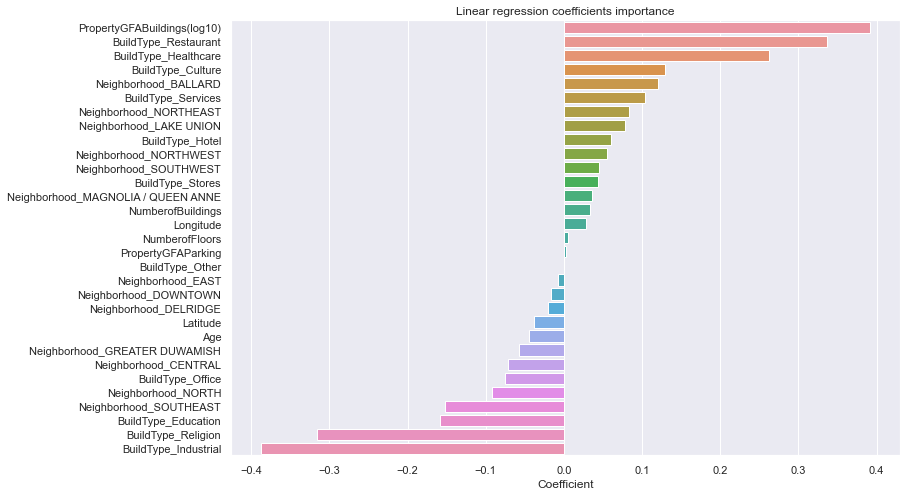

In [ ]:
# Display features coefficents
plt.figure(figsize=(12,8))
plt.title("Linear regression coefficients importance")
sns.barplot(x=lr_importances, y=lr_importances.index, order=lr_importances.sort_values(ascending=False).index)
plt.xlabel("Coefficient")
plt.show()

I compute the R squared score on both the training set and testing set.

In [ ]:
# R squared
lr_train_score = lr.score(x_train,y_train)*100
lr_test_score = lr.score(x_test,y_test)*100

print("R squared: {:.2f} (train)".format(lr_train_score))
print("R squared: {:.2f} (test)".format(lr_test_score))

R squared: 71.20 (train)
R squared: 53.74 (test)


The R2 score on the training set is not very good (43%) and negative on the testing set, which is bad.

I decide to use the sklearn cross validation on the testing set to confirm the obtained score.

In [ ]:
# Cross validation
lr_scores = cross_validate(lr, x_train, y_train, cv=5, 
                                           scoring='r2', 
                                           return_train_score=True)

print("R squared: {:.2f} (train cross validation)".format(lr_scores['train_score'].mean()*100))
print("R squared: {:.2f} (test cross validation)".format(lr_scores['test_score'].mean()*100))

R squared: 68.77 (train cross validation)
R squared: 66.45 (test cross validation)


I use the linear regression model to predict the values on the testing set.

In [ ]:
#Prediction of test set
y_pred_lr = lr.predict(x_test)

I create a dataframe with the real values and the predicted values.

In [ ]:
# Actual value and the predicted value
lr_diff = pd.DataFrame({'Real': y_test, 'LR_Predict': y_pred_lr})

# Add error percentage
lr_diff['LR_Percentage_Error'] = abs((y_pred_lr - y_test) / y_test) * 100 # Make sure y_test non null
display(lr_diff.head())

Real  LR_Predict  LR_Percentage_Error
912   6.317445    5.933768             6.073286
1030  7.088151    6.552117             7.562393
999   6.239549    6.038811             3.217187
487   7.406167    6.812421             8.016917
1192  6.442765    5.985370             7.099355

In [ ]:
print("Mean Percentage Error: {:.2f}%".format(lr_diff['LR_Percentage_Error'].mean()))

Mean Percentage Error: 4.45%


I evaluate the model with several metrics.

In [ ]:
# Model Evaluation
lr_meanAbErr = metrics.mean_absolute_error(y_test, y_pred_lr)
lr_meanAbPerErr = metrics.mean_absolute_percentage_error(y_test, y_pred_lr)
lr_meanSqErr = metrics.mean_squared_error(y_test, y_pred_lr)
lr_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))

print("Mean Absolute Error:", lr_meanAbErr)
print("Mean Absolute Percentage Error:", lr_meanAbPerErr)
print("Mean Square Error:", lr_meanSqErr)
print("Root Mean Square Error:", lr_rootMeanSqErr)

Mean Absolute Error: 0.28372309733653756
Mean Absolute Percentage Error: 0.04446795290510856
Mean Square Error: 0.17142862072248635
Root Mean Square Error: 0.41403939513346594


## Random forest

I use the sklearn random forest regressor model.

In [ ]:
# Random forest regressor model
rf = RandomForestRegressor(random_state=0)

# Check current parameters
print("Random forest current parameters:")
pprint(rf.get_params())

Random forest current parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


I implement the standard model on the testing set.

In [ ]:
# Fitting the random forest regressor model
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

Then I decide to use a search grid to tune the hyperparameters of the random forest regressor model.

In [ ]:
# Number of trees in random forest
n_estimators = [20, 50, 100, 500, 1000]

# Maximum number of levels in tree
max_depth = [5, 10, 50, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
rf_search_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

print("Random forest parameters search grid:")
pprint(rf_search_grid)

Random forest parameters search grid:
{'bootstrap': [True, False],
 'max_depth': [5, 10, 50, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 50, 100, 500, 1000]}


I search for the best parameters and fit the model to the training set.

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
rf_search = GridSearchCV(estimator=rf, param_grid=rf_search_grid, cv=3, verbose=2, n_jobs=-1,
                         return_train_score=True)

# Fit the random search model
rf_search.fit(x_train, y_train);

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END boots

In [ ]:
rf_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

I decide to compare the scores between the standard model and the tuned model on the testing set.

In [ ]:
print("\n")
print("Testing set:")
# R squared
print("R squared: {:.2f} (standard model)".format(rf.score(x_test,y_test)*100))
print("R squared: {:.2f} (tuned model)".format(rf_search.best_estimator_.score(x_test,y_test)*100))

# Average errors
print("Average Error: {:0.4f} (standard model)".format(np.mean(abs(rf.predict(x_test) - y_test))))
print("Average Error: {:0.4f} (tuned model)".format(np.mean(abs(rf_search.best_estimator_.predict(x_test) - y_test))))



Testing set:
R squared: 59.40 (standard model)
R squared: 60.27 (tuned model)
Average Error: 0.2707 (standard model)
Average Error: 0.2732 (tuned model)


The random forest with tuned parameters gives a slightly better R squared and a slightly worst average error results than the standard model (with default parameters).

Here I decide to go with the tuned model.

I recreate an estimator with the best parameters founds.

In [ ]:
# Random forest regressor model
rf = RandomForestRegressor(random_state=0, 
                           bootstrap=rf_search.best_params_.get('bootstrap'),
                           max_depth=rf_search.best_params_.get('max_depth'),
                           min_samples_leaf=rf_search.best_params_.get('min_samples_leaf'),
                           min_samples_split=rf_search.best_params_.get('min_samples_split'),
                           n_estimators=rf_search.best_params_.get('n_estimators'))

# Fitting the random forest regressor model
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=50, random_state=0)

Now let's see the feature importance from the model.

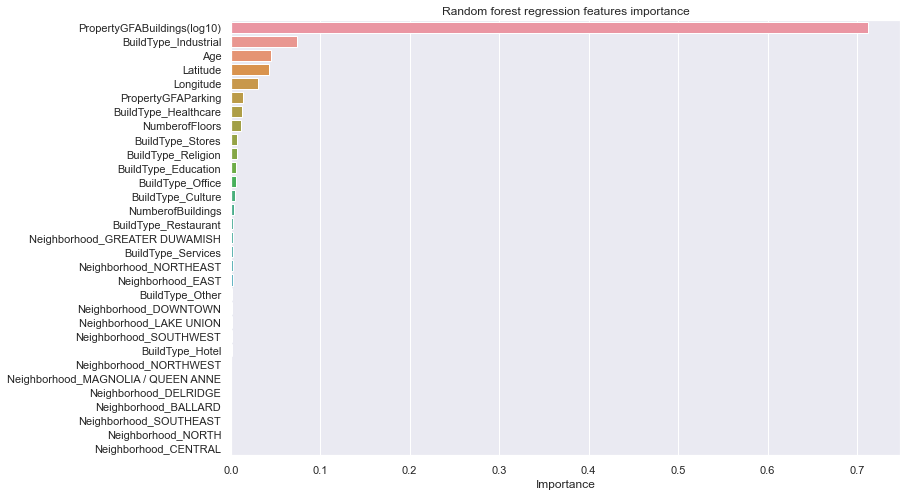

In [ ]:
# Create importance serie
rf_importances = pd.Series(rf.feature_importances_, index=features)

# Display importances
plt.figure(figsize=(12,8))
plt.title("Random forest regression features importance")
sns.barplot(x=rf_importances, y=rf_importances.index, order=rf_importances.sort_values(ascending=False).index)
plt.xlabel("Importance")
plt.show()

I compute the R squared score on both the training set and testing set.

In [ ]:
# R squared
rf_train_score = rf.score(x_train,y_train)*100
rf_test_score = rf.score(x_test,y_test)*100

print("R squared: {:.2f} (train)".format(rf_train_score))
print("R squared: {:.2f} (test)".format(rf_test_score))

R squared: 87.70 (train)
R squared: 60.27 (test)


I use the random forest model to predict the values on the testing set.

In [ ]:
#Prediction of test set
y_pred_rf = rf.predict(x_test)

I create a dataframe with the real values and the predicted values.

In [ ]:
# Actual value and the predicted value
rf_diff = pd.DataFrame({'Real': y_test, 'RF_Predict': y_pred_rf})

# Add error percentage
rf_diff['RF_Percentage_Error'] = abs((y_pred_rf - y_test) / y_test) * 100 # Make sure y_test non null
display(rf_diff.head())

Real  RF_Predict  RF_Percentage_Error
912   6.317445    6.279937             0.593710
1030  7.088151    6.640924             6.309504
999   6.239549    6.039658             3.203606
487   7.406167    6.956125             6.076586
1192  6.442765    6.000426             6.865666

In [ ]:
print("Mean Percentage Error: {:.2f}%".format(rf_diff['RF_Percentage_Error'].mean()))

Mean Percentage Error: 4.29%


I evaluate the model with several metrics on the testing set.

In [ ]:
# Model Evaluation
rf_r2Score = metrics.r2_score(y_test, y_pred_rf) 
rf_meanAbErr = metrics.mean_absolute_error(y_test, y_pred_rf)
rf_meanAbPerErr = metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
rf_meanSqErr = metrics.mean_squared_error(y_test, y_pred_rf)
rf_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))

print("Mean Absolute Error:", rf_meanAbErr)
print("Mean Absolute Percentage Error:", rf_meanAbPerErr)
print("Mean Square Error:", rf_meanSqErr)
print("Root Mean Square Error:", rf_rootMeanSqErr)

Mean Absolute Error: 0.2732439277329661
Mean Absolute Percentage Error: 0.04294962064767682
Mean Square Error: 0.14721677843686282
Root Mean Square Error: 0.3836883871540326


## XGBoost

I use the extrem gradient boosting regressor model.

In [ ]:
# XGBoost regressor model
xgbr = xgb.XGBRegressor(random_state=0, objective='reg:squarederror')

# Check current parameters
print("XGBoost parameters:")
pprint(xgbr.get_params())

XGBoost parameters:
{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'predictor': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


I implement the gradient boosting model on the training set.

In [ ]:
# Fitting the gradient boosting model
xgbr.fit(x_train.to_numpy(), y_train.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Then I decide to use a search grid to tune the hyperparameters of the gradien boosting regressor model.

In [ ]:
# Number of trees in random forest
n_estimators = [20, 50, 100, 500, 1000]

# Maximum number of levels in tree
max_depth = [1, 3, 5, 10]

# Learning rate used to weight each model
learning_rate = [0.05, 0.10, 0.15]

# Number of samples (rows) used in each tree
subsample = [0.5, 0.8, 1]

# Number of features (columns) used in each tree
colsample_bytree = [0.5, 0.8, 1]

# Create the random grid
xgbr_search_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate': learning_rate,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree}

print("XGBoost parameters search grid:")
pprint(xgbr_search_grid)

XGBoost parameters search grid:
{'colsample_bytree': [0.5, 0.8, 1],
 'learning_rate': [0.05, 0.1, 0.15],
 'max_depth': [1, 3, 5, 10],
 'n_estimators': [20, 50, 100, 500, 1000],
 'subsample': [0.5, 0.8, 1]}


I search for the best parameters and fit the estimator to the training set.

In [ ]:
# Grid search of parameters, using 3 fold cross validation, 
xgbr_search = GridSearchCV(estimator=xgbr, param_grid=xgbr_search_grid, cv=3, verbose=2, n_jobs=-1,
                         return_train_score=True)

# Fit the random search model
xgbr_search.fit(x_train, y_train);

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=1; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=1; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=1, n_estimators=20, subsample=1; total time=   0.0s
[CV] END colsample_byt

In [ ]:
xgbr_search.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 1,
 'n_estimators': 500,
 'subsample': 0.5}

I decide to compare the scores between the standard model and the tuned model on the training set.

In [ ]:
print("\n")
print("Testing set:")
# R squared
print("R squared: {:.2f} (standard model)".format(xgbr.score(x_test,y_test)*100))
print("R squared: {:.2f} (tuned model)".format(xgbr_search.best_estimator_.score(x_test,y_test)*100))

# Average errors
print("Average Error: {:0.4f} (standard model)".format(np.mean(abs(xgbr.predict(x_test) - y_test))))
print("Average Error: {:0.4f} (tuned model)".format(np.mean(abs(xgbr_search.best_estimator_.predict(x_test) - y_test))))



Testing set:
R squared: 57.59 (standard model)
R squared: 58.69 (tuned model)
Average Error: 0.2793 (standard model)
Average Error: 0.2777 (tuned model)


The gradient boosting with tuned parameters gives slightly better results than the standard model (with default parameters).

Here I decide to go with the tuned model.

I recreate an estimator with the best parameters founds.

In [ ]:
# XGBoost regressor model
xgbr = xgb.XGBRegressor(random_state=0, objective='reg:squarederror',
                        colsample_bytree=xgbr_search.best_params_.get('colsample_bytree'),
                        learning_rate=xgbr_search.best_params_.get('learning_rate'),
                        max_depth=xgbr_search.best_params_.get('max_depth'),
                        n_estimators=xgbr_search.best_params_.get('n_estimators'),
                        subsample=xgbr_search.best_params_.get('subsample'))

# Fitting the gradient boosting model
xgbr.fit(x_train.to_numpy(), y_train.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Now let's see the feature importance from the model.

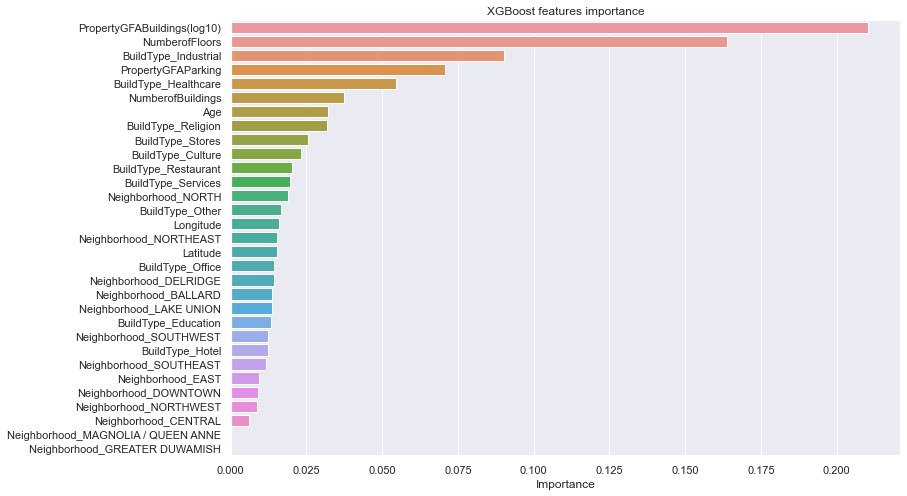

In [ ]:
# Create importance serie
xgbr_importances = pd.Series(xgbr.feature_importances_, index=features)

# Display importances
plt.figure(figsize=(12,8))
plt.title("XGBoost features importance")
sns.barplot(x=xgbr_importances, y=xgbr_importances.index, order=xgbr_importances.sort_values(ascending=False).index)
plt.xlabel("Importance")
plt.show()

I compute the R squared score on both the training set and testing set.

In [ ]:
# R squared
xgbr_train_score = xgbr.score(x_train.to_numpy(),y_train.to_numpy())*100
xgbr_test_score = xgbr.score(x_test.to_numpy(),y_test.to_numpy())*100

print("R squared: {:.2f} (train)".format(xgbr_train_score))
print("R squared: {:.2f} (test)".format(xgbr_test_score))

R squared: 73.20 (train)
R squared: 58.69 (test)


I use the gradient boosting model to predict the values on the testing set.

In [ ]:
#Prediction of test set
y_pred_xgbr = xgbr.predict(x_test.to_numpy())

I create a dataframe with the real values and the predicted values.

In [ ]:
# Actual value and the predicted value
xgbr_diff = pd.DataFrame({'Real': y_test, 'XGB_Predict': y_pred_xgbr})

# Add error percentage
xgbr_diff['XGB_Percentage_Error'] = abs((y_pred_xgbr - y_test) / y_test) * 100 # Make sure y_test non null
display(xgbr_diff.head())

Real  XGB_Predict  XGB_Percentage_Error
912   6.317445     6.042330              4.354845
1030  7.088151     6.524870              7.946792
999   6.239549     5.971192              4.300893
487   7.406167     6.857429              7.409207
1192  6.442765     6.024637              6.489890

In [ ]:
print("Mean Percentage Error: {:.2f}%".format(xgbr_diff['XGB_Percentage_Error'].mean()))

Mean Percentage Error: 4.36%


I evaluate the model with several metrics.

In [ ]:
# Model Evaluation
xgbr_meanAbErr = metrics.mean_absolute_error(y_test, y_pred_xgbr)
xgbr_meanAbPerErr = metrics.mean_absolute_percentage_error(y_test, y_pred_xgbr)
xgbr_meanSqErr = metrics.mean_squared_error(y_test, y_pred_xgbr)
xgbr_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgbr))

print("Mean Absolute Error:", xgbr_meanAbErr)
print("Mean Absolute Percentage Error:", xgbr_meanAbPerErr)
print("Mean Square Error:", xgbr_meanSqErr)
print("Root Mean Square Error:", xgbr_rootMeanSqErr)

Mean Absolute Error: 0.27772389145384807
Mean Absolute Percentage Error: 0.04357883592438085
Mean Square Error: 0.1530757984728797
Root Mean Square Error: 0.39124902360629565


# Compare the models

I create a dataframe with all models metrics.

In [ ]:
# Create metrics dataframe
metrics_df = pd.DataFrame({'R2_train': [lr_train_score, rf_train_score, xgbr_train_score],
                           'R2_test': [lr_test_score, rf_test_score, xgbr_test_score],
                           'MAE': [lr_meanAbErr, rf_meanAbErr, xgbr_meanAbErr],
                           'MAPE': [lr_meanAbPerErr, rf_meanAbPerErr, xgbr_meanAbPerErr],
                           'MSE': [lr_meanSqErr, rf_meanSqErr, xgbr_meanSqErr],
                           'RMSE': [lr_rootMeanSqErr, rf_rootMeanSqErr, xgbr_rootMeanSqErr]},
                           index=['LinearRegression', 'RandomForest', 'XGBoost'])
display(metrics_df)

R2_train    R2_test       MAE      MAPE       MSE      RMSE
LinearRegression  71.200319  53.739435  0.283723  0.044468  0.171429  0.414039
RandomForest      87.697328  60.273078  0.273244  0.042950  0.147217  0.383688
XGBoost           73.200976  58.692003  0.277724  0.043579  0.153076  0.391249

From the results of R2 score, MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error), it appears the random forest regressor has better results on the test train. 

I display the predictions results on the test set.

In [ ]:
# Create a dataframe with the prediction results
pred_df = pd.concat([lr_diff[['Real', 'LR_Predict']], rf_diff['RF_Predict'], xgbr_diff['XGB_Predict']], axis=1)

display(pred_df.head(10))

Real  LR_Predict  RF_Predict  XGB_Predict
912   6.317445    5.933768    6.279937     6.042330
1030  7.088151    6.552117    6.640924     6.524870
999   6.239549    6.038811    6.039658     5.971192
487   7.406167    6.812421    6.956125     6.857429
1192  6.442765    5.985370    6.000426     6.024637
1052  6.446603    6.031091    5.923526     5.988478
542   7.210749    6.993065    7.137958     7.131198
1566  7.273251    7.524836    7.372066     7.361130
1187  6.993492    6.334759    6.117069     6.185672
412   6.823301    7.062102    7.106932     7.083199

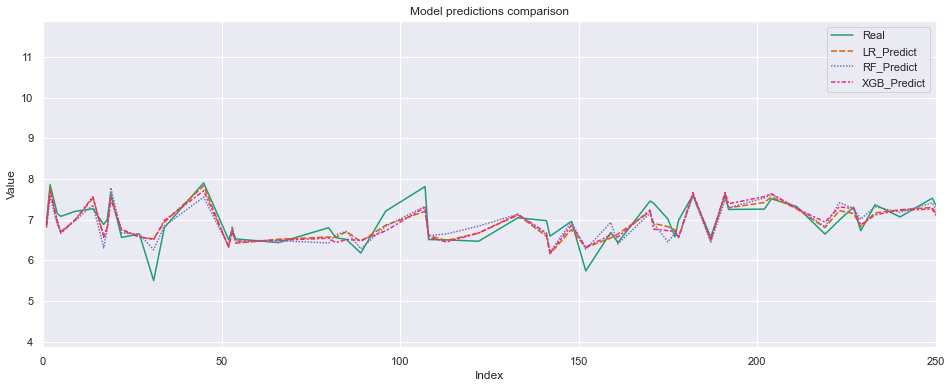

In [ ]:
# Lineplot 
plt.figure(figsize=(16,6))
plt.title("Model predictions comparison")
lineplot = sns.lineplot(data=pred_df)
lineplot.set_xlim(0, 250)
# lineplot.set_ylim(0, 5000)
plt.ylabel("Value")
plt.xlabel("Index")
plt.show()

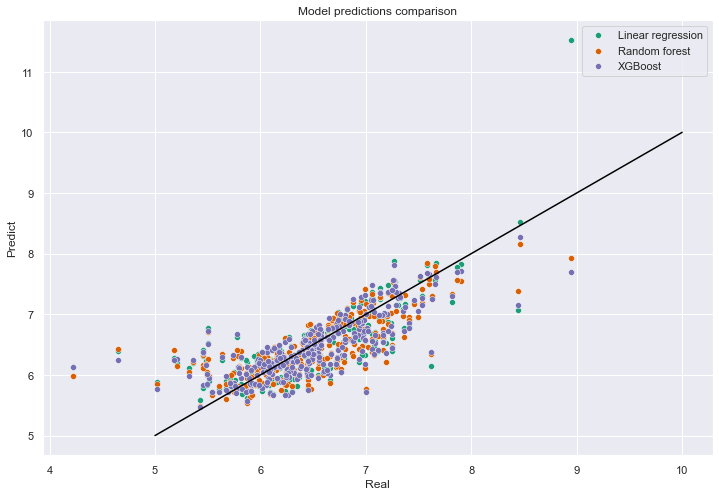

In [ ]:
# Scatter plot
plt.figure(figsize=(12,8))
plt.title("Model predictions comparison")
scatterplot = sns.scatterplot(x='Real', y='LR_Predict', data=pred_df)
sns.scatterplot(x='Real', y='RF_Predict', data=pred_df, ax=scatterplot)
sns.scatterplot(x='Real', y='XGB_Predict', data=pred_df, ax=scatterplot)
plt.legend(labels=['Linear regression', 'Random forest', 'XGBoost'])
plt.ylabel('Predict')
# Create x=y line
plt.plot([5, 10],[5, 10], color='black')
# Zoom on figure
# scatterplot.set_xlim(0, 20)
# scatterplot.set_ylim(0, 20)
plt.show()

I decide to confirm the results with cross validating (with 5 folds) the three models with the negative root mean squared error metric.

This time I use directly x and y as the training and testing split is done within the cross validation with the folds.

In [ ]:
# Define scoring 
scoring = "neg_root_mean_squared_error"

# Evaluate each model
lr_scores = cross_validate(lr, x, y, scoring=scoring, return_estimator=True)
rf_scores = cross_validate(rf, x, y, scoring=scoring, return_estimator=True)
xgbr_scores = cross_validate(xgbr, x, y, scoring=scoring, return_estimator=True)

# Print scores
print("Mean of negative RMSE")
print("Linear regression: ", lr_scores["test_score"].mean())
print("Random forest: ", rf_scores["test_score"].mean())
print("xgbr_scores: ", xgbr_scores["test_score"].mean())

Mean of negative RMSE
Linear regression:  -0.33508490396298773
Random forest:  -0.33618821493354384
xgbr_scores:  -0.33075918013998484


I display the scores results.

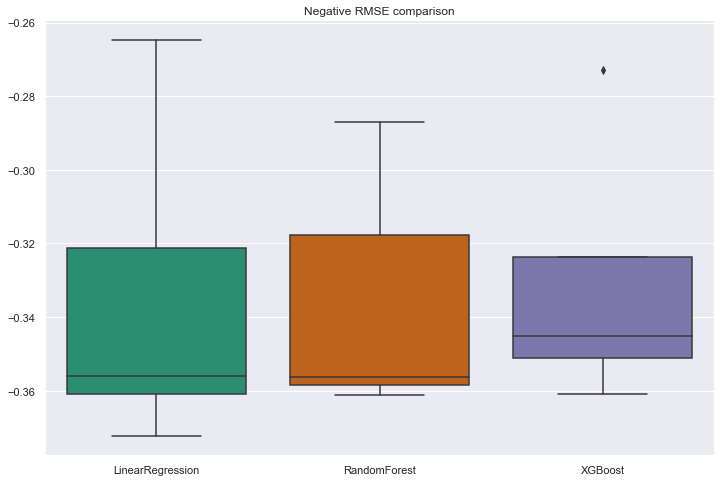

In [ ]:
# Boxplot of scoring
plt.figure(figsize=(12,8))
plt.title("Negative RMSE comparison")
r2_boxplot = sns.boxplot(data=[lr_scores["test_score"], rf_scores["test_score"], xgbr_scores["test_score"]])
r2_boxplot.set_xticklabels(['LinearRegression', 'RandomForest', 'XGBoost'])
plt.xlabel("")
plt.show()

It appears this time after using the cross validation, its the XGBoost model who seems to have better results.

Here I decide to keep the random forest model for the rest of the study.

# Model explainer

I use the lime package to explain the random forest regressor on particular values.

Let's try for example on the index=200.

In [ ]:
# Instantiating the explainer object by passing in the training set, and the extracted features
explainer_lime = lime.lime_tabular.LimeTabularExplainer(x_train.to_numpy(),
                                                        feature_names=features,
                                                        verbose=True, mode='regression')
# Index corresponding to the test vector
i = 200
 
# Number denoting the top features
k = 10
 
# Calling the explain_instance method by passing in the:
#    1) ith test vector
#    2) prediction function used by our prediction model
#    3) the top features which we want to see, denoted by k
exp_lime = explainer_lime.explain_instance(
    x_test.iloc[i], rf.predict, num_features=k)

# Display real value
print("Real value :", y_test.iloc[i])

# Finally visualizing the explanations
exp_lime.show_in_notebook()

Intercept 6.862491425675682
Prediction_local [6.04239786]
Right: 6.143190107473114
Real value : 5.794563109332493


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# ENERGYSTARScore

I selected the random forest regressor as the best algorithm for the prediction of green house gas emissions.

Now I want to see if adding the variable *ENERGYSTARScore* to the features changes the results of the regression.

First I add the *ENERGYSTARScore* variable.

In [ ]:
# Add energy star score variable to the feature
features.append('ENERGYSTARScore')

# Redefine X 
x = data[features]

print(x.shape)

(1596, 32)


Resplit the dataset to a training and testing set.

In [ ]:
# Create sets from x and y
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

# Standardize dataset
scaler = preprocessing.StandardScaler()

# Select non one hot encoded columns
features_to_scale  = not_ohe_columns

# Fit on train set
x_train[features_to_scale] = pd.DataFrame(scaler.fit_transform(x_train[features_to_scale]), index=x_train.index, columns=features_to_scale)
  
# Apply on test set
x_test[features_to_scale] = pd.DataFrame(scaler.transform(x_test[features_to_scale]), index=x_test.index, columns=features_to_scale)

display(x_train.describe())
display(x_test.describe())

Age  BuildType_Culture  BuildType_Education  \
count  1.276000e+03        1276.000000          1276.000000   
mean   2.227407e-17           0.052508             0.108150   
std    1.000392e+00           0.223136             0.310692   
min   -1.655993e+00           0.000000             0.000000   
25%   -8.225046e-01           0.000000             0.000000   
50%   -8.162628e-02           0.000000             0.000000   
75%    9.679513e-01           0.000000             0.000000   
max    1.894049e+00           1.000000             1.000000   

       BuildType_Healthcare  BuildType_Hotel  BuildType_Industrial  \
count           1276.000000      1276.000000           1276.000000   
mean               0.046238         0.046238              0.189655   
std                0.210083         0.210083              0.392182   
min                0.000000         0.000000              0.000000   
25%                0.000000         0.000000              0.000000   
50%                0.000000         0.000000              0.000000   
75%                0.000000         0.000000              0.000000   
max                1.000000         1.000000              1.000000   

       BuildType_Office  BuildType_Other  BuildType_Religion  \
count       1276.000000      1276.000000         1276.000000   
mean           0.318966         0.061129            0.043887   
std            0.466258         0.239660            0.204924   
min            0.000000         0.000000            0.000000   
25%            0.000000         0.000000            0.000000   
50%            0.000000         0.000000            0.000000   
75%            1.000000         0.000000            0.000000   
max            1.000000         1.000000            1.000000   

       BuildType_Restaurant  ...  Neighborhood_NORTH  Neighborhood_NORTHEAST  \
count           1276.000000  ...         1276.000000             1276.000000   
mean               0.007837  ...            0.039969                0.069749   
std                0.088214  ...            0.195962                0.254824   
min                0.000000  ...            0.000000                0.000000   
25%                0.000000  ...            0.000000                0.000000   
50%                0.000000  ...            0.000000                0.000000   
75%                0.000000  ...            0.000000                0.000000   
max                1.000000  ...            1.000000                1.000000   

       Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  \
count             1276.000000             1276.000000             1276.000000   
mean                 0.054075                0.028213                0.026646   
std                  0.226255                0.165646                0.161109   
min                  0.000000                0.000000                0.000000   
25%                  0.000000                0.000000                0.000000   
50%                  0.000000                0.000000                0.000000   
75%                  0.000000                0.000000                0.000000   
max                  1.000000                1.000000                1.000000   

       NumberofBuildings  NumberofFloors  PropertyGFABuildings(log10)  \
count       1.276000e+03    1.276000e+03                 1.276000e+03   
mean       -3.201897e-17    8.352775e-18                 1.782621e-15   
std         1.000392e+00    1.000392e+00                 1.000392e+00   
min        -1.119525e-01   -6.553036e-01                -1.848857e+00   
25%        -1.119525e-01   -4.934125e-01                -7.725986e-01   
50%        -1.119525e-01   -3.315215e-01                -2.290640e-01   
75%        -1.119525e-01   -7.739307e-03                 5.472250e-01   
max         2.075398e+01    1.164842e+01                 4.043688e+00   

       PropertyGFAParking  ENERGYSTARScore  
count        1.276000e+03      1276.000000  
mean         1.670555e-17        65.82131

Age  BuildType_Culture  BuildType_Education  \
count  320.000000         320.000000           320.000000   
mean    -0.029051           0.050000             0.059375   
std      1.042745           0.218286             0.236695   
min     -1.655993           0.000000             0.000000   
25%     -0.915114           0.000000             0.000000   
50%     -0.189671           0.000000             0.000000   
75%      0.998821           0.000000             0.000000   
max      1.894049           1.000000             1.000000   

       BuildType_Healthcare  BuildType_Hotel  BuildType_Industrial  \
count            320.000000       320.000000            320.000000   
mean               0.040625         0.059375              0.196875   
std                0.197729         0.236695              0.398260   
min                0.000000         0.000000              0.000000   
25%                0.000000         0.000000              0.000000   
50%                0.000000         0.000000              0.000000   
75%                0.000000         0.000000              0.000000   
max                1.000000         1.000000              1.000000   

       BuildType_Office  BuildType_Other  BuildType_Religion  \
count        320.000000       320.000000          320.000000   
mean           0.306250         0.075000            0.046875   
std            0.461657         0.263804            0.211702   
min            0.000000         0.000000            0.000000   
25%            0.000000         0.000000            0.000000   
50%            0.000000         0.000000            0.000000   
75%            1.000000         0.000000            0.000000   
max            1.000000         1.000000            1.000000   

       BuildType_Restaurant  ...  Neighborhood_NORTH  Neighborhood_NORTHEAST  \
count            320.000000  ...          320.000000              320.000000   
mean               0.018750  ...            0.037500                0.071875   
std                0.135853  ...            0.190281                0.258685   
min                0.000000  ...            0.000000                0.000000   
25%                0.000000  ...            0.000000                0.000000   
50%                0.000000  ...            0.000000                0.000000   
75%                0.000000  ...            0.000000                0.000000   
max                1.000000  ...            1.000000                1.000000   

       Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  \
count              320.000000              320.000000              320.000000   
mean                 0.040625                0.018750                0.015625   
std                  0.197729                0.135853                0.124214   
min                  0.000000                0.000000                0.000000   
25%                  0.000000                0.000000                0.000000   
50%                  0.000000                0.000000                0.000000   
75%                  0.000000                0.000000                0.000000   
max                  1.000000                1.000000                1.000000   

       NumberofBuildings  NumberofFloors  PropertyGFABuildings(log10)  \
count         320.000000      320.000000                   320.000000   
mean            0.266744        0.031722                     0.013389   
std             4.965038        1.033751                     1.071055   
min            -0.111953       -0.655304                    -1.797695   
25%            -0.111953       -0.493413                    -0.818771   
50%            -0.111953       -0.331521                    -0.251806   
75%            -0.111953       -0.007739                     0.571968   
max            88.167012        6.144122                     5.647258   

       PropertyGFAParking  ENERGYSTARScore  
count          320.000000       320.000000  
mean             0.066401        64.721354  
std         

I implement the random forest regressor model with standard parameters to the dataset.

In [ ]:
# Random forest regressor model
rf = RandomForestRegressor(random_state=0)

# Check current parameters
print("Random forest current parameters:")
pprint(rf.get_params())

# Fitting the random forest regressor model
rf.fit(x_train, y_train)

Random forest current parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


RandomForestRegressor(random_state=0)

Let's see the feature importance from the model.

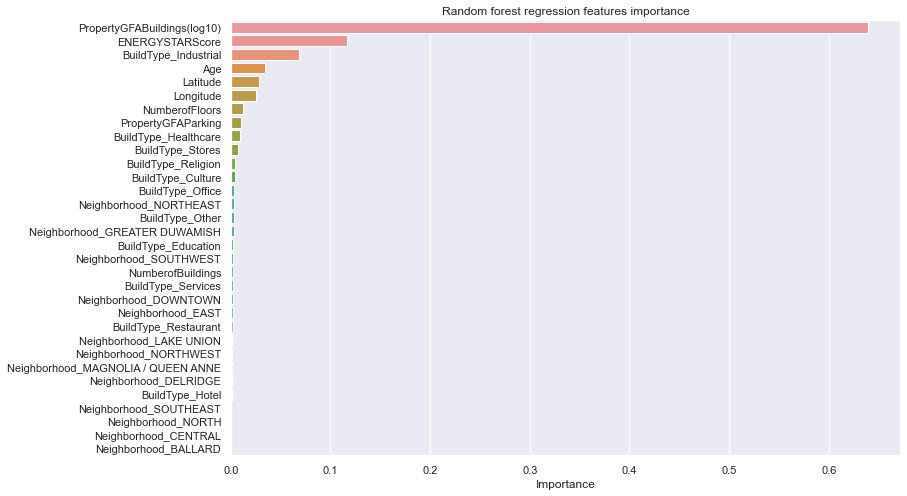

In [ ]:
# Create importance serie
rf_importances = pd.Series(rf.feature_importances_, index=features)

# Display importances
plt.figure(figsize=(12,8))
plt.title("Random forest regression features importance")
sns.barplot(x=rf_importances, y=rf_importances.index, order=rf_importances.sort_values(ascending=False).index)
plt.xlabel("Importance")
plt.show()

The variable ENERGYSTARScore is on the top 5 features for the random forest model.

Let's see the associated score on the training and testing sets.

In [ ]:
# R squared
rf2_train_score = rf.score(x_train,y_train)*100
rf2_test_score = rf.score(x_test,y_test)*100

print("R squared: {:.2f} (train)".format(rf2_train_score))
print("R squared: {:.2f} (test)".format(rf2_test_score))

R squared: 96.34 (train)
R squared: 72.85 (test)


Predict the values on the test set and add to the random forest dataframe.

In [ ]:
#Prediction of test set
rf_diff['RF_Predict_STAR'] = rf.predict(x_test)

# Add error percentage
rf_diff['RF_Percentage_Error_STAR'] = abs((rf_diff['RF_Predict_STAR'] - y_test) / y_test) * 100 # Make sure y_test non null
display(rf_diff.head())

Real  RF_Predict  RF_Percentage_Error  RF_Predict_STAR  \
912   6.317445    6.279937             0.593710         6.282433   
1030  7.088151    6.640924             6.309504         6.842049   
999   6.239549    6.039658             3.203606         6.109617   
487   7.406167    6.956125             6.076586         7.290349   
1192  6.442765    6.000426             6.865666         6.205929   

      RF_Percentage_Error_STAR  
912                   0.554211  
1030                  3.472018  
999                   2.082394  
487                   1.563807  
1192                  3.676002

In [ ]:
print("Mean Percentage Error: {:.2f}%".format(rf_diff['RF_Percentage_Error'].mean()))
print("Mean Percentage Error: {:.2f}% (with ENERGYSTARScore)".format(rf_diff['RF_Percentage_Error_STAR'].mean()))

Mean Percentage Error: 4.29%
Mean Percentage Error: 3.38% (with ENERGYSTARScore)


Compare the mectrics with and without the variable *ENERGYSTARScore*.

In [ ]:
rf2_r2Score = metrics.r2_score(y_test, rf_diff['RF_Predict_STAR']) 
rf2_meanAbErr = metrics.mean_absolute_error(y_test, rf_diff['RF_Predict_STAR'])
rf2_meanAbPerErr = metrics.mean_absolute_percentage_error(y_test, rf_diff['RF_Predict_STAR'])
rf2_meanSqErr = metrics.mean_squared_error(y_test, rf_diff['RF_Predict_STAR'])
rf2_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, rf_diff['RF_Predict_STAR']))

# Create metrics dataframe
rf_metrics_df = pd.DataFrame({'R2_train': [rf_train_score, rf2_train_score],
                           'R2_test': [rf_test_score, rf2_test_score],
                           'MAE': [rf_meanAbErr, rf2_meanAbErr],
                           'MAPE': [rf_meanAbPerErr, rf2_meanAbPerErr],
                           'MSE': [rf_meanSqErr, rf2_meanSqErr],
                           'RMSE': [rf_rootMeanSqErr, rf2_rootMeanSqErr],
                           'ENERGYSTARScore': [False, True]})
display(rf_metrics_df)

R2_train    R2_test       MAE      MAPE       MSE      RMSE  \
0  87.697328  60.273078  0.273244  0.042950  0.147217  0.383688   
1  96.337531  72.854104  0.217381  0.033763  0.100595  0.317167   

   ENERGYSTARScore  
0            False  
1             True

I compute the difference on R2 and RMSE on the testing set.

In [ ]:
# R2 diff
star_r2_diff = ((rf2_test_score - rf_test_score) / rf_test_score)*100

# RMSE diff
star_rmse_diff = ((rf2_rootMeanSqErr - rf_rootMeanSqErr) / rf_rootMeanSqErr)*100

print("The ENERGYSTARScore variable increases results by:")
print("R squared : {:.2f}%".format(star_r2_diff))
print("RMSE : {:.2f}%".format(star_rmse_diff))

The ENERGYSTARScore variable increases results by:
R squared : 20.87%
RMSE : -17.34%


I decide to use the lime explainer again to see the differences.

In [ ]:
# Instantiating the explainer object by passing in the training set, and the extracted features
explainer_lime = lime.lime_tabular.LimeTabularExplainer(x_train.to_numpy(),
                                                        feature_names=features,
                                                        verbose=True, mode='regression')
# Index corresponding to the test vector
i = 200
 
# Number denoting the top features
k = 10
 
# Calling the explain_instance method by passing in the:
#    1) ith test vector
#    2) prediction function used by our prediction model
#    3) the top features which we want to see, denoted by k
exp_lime = explainer_lime.explain_instance(
    x_test.iloc[i], rf.predict, num_features=k)

# Display real value
print("Real value :", y_test.iloc[i])

# Finally visualizing the explanations
exp_lime.show_in_notebook()

Intercept 6.6502398973440195
Prediction_local [5.86872109]
Right: 6.002169005932153
Real value : 5.794563109332493


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**Conclusion:** the variable *ENERGYSTARScore* is helpful for the prediction and increases the accuracy by approximately 20%.